In [ ]:
!fusermount -u /content/drive

fusermount: failed to unmount /content/drive: No such file or directory


In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# パスをGoogleドライブ内のものに変更}
# （例：マイドライブの直下に置いた場合）
file_path = '/content/drive/MyDrive/data_lowF_noise.pickle'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# データが読み込めたか確認
# print(data)

In [ ]:
from pathlib import Path
from google.colab import drive

# Google Drive をマウント
drive.mount('/content/drive')

# 学習結果の保存先（好きなフォルダ名でOK）
BASE_OUT_DIR = Path("/content/drive/MyDrive/noise_point_output")
BASE_OUT_DIR.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
############################################################
# 0. imports & device
############################################################
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


############################################################
# 1. 外的ノイズ生成関数
############################################################

# ------- 電源ノイズ（50 Hz 高調波 + 2 kHz スイッチング） -------
def add_power_supply_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                           freq_min=0.0, freq_max=15000.0):
    """
    psd_data: torch.Tensor (L,)
    """
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    base_amplitude = psd_data.mean() * noise_level

    # 電源周波数と高調波
    power_freq = 50.0
    harmonics = [1, 2, 3]  # 50, 100, 150 Hz
    amplitudes = [0.8, 0.4, 0.2]

    for h, amp in zip(harmonics, amplitudes):
        freq = power_freq * h
        sigma = 10.0  # 10 Hz 幅
        peak = amp * base_amplitude * torch.exp(-0.5 * ((frequencies - freq) / sigma) ** 2)
        noisy_data += peak

    # スイッチングノイズ (2 kHz)
    switching_freq = 2000.0
    sigma = 100.0
    peak = 0.6 * base_amplitude * torch.exp(-0.5 * ((frequencies - switching_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- 干渉ノイズ（3 kHz ピーク） -------
def add_interference_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                           freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    interference_freq = 3000.0
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude * torch.exp(-0.5 * ((frequencies - interference_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- クロックリーク（5 kHz ピーク） -------
def add_clock_leakage_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                            freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    clock_freq = 5000.0
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude * torch.exp(-0.5 * ((frequencies - clock_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- 統一インターフェース -------
def add_noise_to_interval(psd_data, interval_idx, noise_type="power_supply",
                          noise_level=0.1, num_intervals=30,
                          freq_min=0.0, freq_max=15000.0):
    if noise_type == "power_supply":
        return add_power_supply_noise(psd_data, interval_idx,
                                      noise_level=noise_level,
                                      num_intervals=num_intervals,
                                      freq_min=freq_min,
                                      freq_max=freq_max)
    elif noise_type == "interference":
        return add_interference_noise(psd_data, interval_idx,
                                      noise_level=noise_level,
                                      num_intervals=num_intervals,
                                      freq_min=freq_min,
                                      freq_max=freq_max)
    elif noise_type == "clock_leakage":
        return add_clock_leakage_noise(psd_data, interval_idx,
                                       noise_level=noise_level,
                                       num_intervals=num_intervals,
                                       freq_min=freq_min,
                                       freq_max=freq_max)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")


############################################################
# 2. 実験環境ノイズ（構造化ノイズ：位置依存ガウス + ソフトクリップ）
############################################################

def process_noise(noise, clip_range=0.5, smoothing_factor=0.1):
    """
    tanhクリップ + 元ノイズとのブレンドで少し滑らかにする
    """
    scaled_noise = noise / clip_range
    processed = torch.tanh(scaled_noise) * clip_range
    smoothed = processed * (1 - smoothing_factor) + noise * smoothing_factor
    return smoothed


def add_structured_noise(psd_data, clip_range=0.5, smoothing_factor=0.1):
    """
    PSD 全体に「位置依存ガウスノイズ」を乗算的に付与して、
    実験環境での揺らぎっぽさを出す
    """
    device_local = psd_data.device
    if psd_data.dim() == 1:
        x = psd_data.unsqueeze(0)  # (1, L)
        squeeze_out = True
    else:
        x = psd_data
        squeeze_out = False

    B, L = x.shape

    pos = torch.linspace(1, L, L, device=device_local)
    var = 0.2 + 0.1 * pos / 1000.0
    var = torch.clamp(var, max=0.3)
    std = torch.sqrt(var)
    std = std.unsqueeze(0).expand(B, L)

    noise = torch.normal(mean=0.0, std=std).to(device_local)
    processed = process_noise(noise, clip_range=clip_range, smoothing_factor=smoothing_factor)

    noisy_psd = x * (1.0 + processed)

    if squeeze_out:
        noisy_psd = noisy_psd.squeeze(0)
    return noisy_psd


############################################################
# 3. データセット（自己教師あり：ノイズ除去 + ノイズ検知）
############################################################

class NoisePointDataset(Dataset):
    """
    data_lowF_noise.pickle から 理想PSD (x) を読み込み、

    - clean_psd: 観測できない真のPSD（pickle由来）
    - structured: add_structured_noise(clean_psd)
                  → 観測できる「きれいなPSD」（環境揺らぎ込み）
    - noisy: add_noise_to_interval(structured, ...)
             → 外的ノイズが乗ったPSD

    学習タスク:
      - 入力: noisy（外的ノイズ + 一部マスク）
      - 出力: structured（観測可能なきれいなPSD）
      - 再構成損失は「外的ノイズ点 + マスク点」のみで計算
      - ノイズ検知は noisy vs structured の差でラベル付け
    """

    def __init__(
        self,
        pickle_path: str,
        mask_ratio: float = 0.15,
        noise_level: float = 0.3,
        use_random_noise: bool = True,
        fixed_noise_type: str = "power_supply",
        structured_noise_clip_range: float = 0.5,
        structured_noise_smoothing_factor: float = 0.1,
        noise_threshold_k: float = 1.0,
        freq_min: float = 0.0,
        freq_max: float = 15000.0,
    ):
        super().__init__()

        self.pickle_path = Path(pickle_path)
        self.mask_ratio = mask_ratio
        self.noise_level = noise_level
        self.use_random_noise = use_random_noise
        self.fixed_noise_type = fixed_noise_type
        self.noise_types = ["power_supply", "interference", "clock_leakage"]
        self.structured_noise_clip_range = structured_noise_clip_range
        self.structured_noise_smoothing_factor = structured_noise_smoothing_factor
        self.noise_threshold_k = noise_threshold_k
        self.freq_min = freq_min
        self.freq_max = freq_max

        # ------- データ読み込み (真のクリーンPSD) -------
        with open(self.pickle_path, "rb") as f:
            data = pickle.load(f)

        if isinstance(data, dict):
            self.x = np.asarray(data["x"], dtype=np.float32)
        else:
            self.x = np.asarray(data, dtype=np.float32)

        # (N, 1, L) → (N, L)
        if self.x.ndim == 3 and self.x.shape[1] == 1:
            self.x = self.x.squeeze(1)

        assert self.x.ndim == 2, f"data shape must be (N, L), got {self.x.shape}"
        self.seq_len = self.x.shape[1]

        # スケールファクタ & 正規化統計（クリーンPSDの log の mean/std）
        self.scale_factor = 2.5e24
        print("クリーンPSDの正規化統計を計算中 (log space)...")
        self.normalization_mean, self.normalization_std = self._compute_clean_log_stats()
        print(f"  normalization_mean = {self.normalization_mean:.6f}")
        print(f"  normalization_std  = {self.normalization_std:.6f}")

        print(f"Dataset loaded:")
        print(f"  Samples: {len(self.x)}")
        print(f"  Sequence length: {self.seq_len}")
        print(f"  Mask ratio: {self.mask_ratio}")
        print(f"  Noise level: {self.noise_level}")
        print(f"  Use random noise type: {self.use_random_noise}")

    def _compute_clean_log_stats(self, num_samples_for_stats: int = 1000):
        """
        正規化は「理想PSD」のlog分布から取っている（ここは元のまま）。
        """
        N = len(self.x)
        num = min(num_samples_for_stats, N)
        np.random.seed(42)
        indices = np.random.choice(N, size=num, replace=False)

        log_list = []

        for idx in indices:
            base_psd = self.x[idx].astype(np.float32)
            base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)

            scaled = base_psd * self.scale_factor
            scaled = np.maximum(scaled, 1e-30)
            log_vals = np.log(scaled)
            log_list.append(log_vals)

        all_log = np.concatenate(log_list, axis=0)
        mean = float(all_log.mean())
        std = float(all_log.std())
        if std < 1e-6:
            std = 1.0
        return mean, std

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        # ------- 理想クリーンPSD（観測不能） -------
        clean_psd = self.x[idx].astype(np.float32)
        clean_psd = np.nan_to_num(clean_psd, nan=0.0, posinf=0.0, neginf=0.0)
        L = clean_psd.shape[0]

        clean_t = torch.from_numpy(clean_psd)  # (L,)

        # ------- 構造化ノイズ（実験環境ノイズ）を付与 → 観測できるきれいなPSD -------
        structured = add_structured_noise(
            clean_t,
            clip_range=self.structured_noise_clip_range,
            smoothing_factor=self.structured_noise_smoothing_factor,
        )  # (L,)

        # ------- 外的ノイズを付与（ノイズ検知のターゲット） -------
        if self.use_random_noise:
            noise_type = np.random.choice(self.noise_types)
        else:
            noise_type = self.fixed_noise_type

        noisy_t, _, _ = add_noise_to_interval(
            structured,
            interval_idx=0,
            noise_type=noise_type,
            noise_level=self.noise_level,
            freq_min=self.freq_min,
            freq_max=self.freq_max,
        )  # (L,)

        # ------- 外的ノイズのラベル -------
        diff = (noisy_t - structured).abs()  # (L,)
        diff_mean = diff.mean()
        diff_std = diff.std()
        threshold = diff_mean + self.noise_threshold_k * diff_std

        noise_mask = diff > threshold
        if noise_mask.sum() == 0:
            # まれに何も引っかからない場合は上位5%をノイズ扱い
            k = max(1, int(0.05 * L))
            topk = torch.topk(diff, k).indices
            noise_mask[topk] = True

        noise_labels = noise_mask.float()  # (L,)

        # ------- BERT風マスク（クリーン領域の一部をマスク） -------
        clean_indices = (~noise_mask).nonzero(as_tuple=False).squeeze(-1)
        if len(clean_indices) > 0:
            num_mask = max(1, int(len(clean_indices) * self.mask_ratio))
            mask_indices = np.random.choice(
                clean_indices.cpu().numpy(),
                size=num_mask,
                replace=False,
            )
        else:
            mask_indices = np.array([], dtype=np.int64)

        mask_positions = torch.zeros(L, dtype=torch.bool)
        if len(mask_indices) > 0:
            mask_positions[mask_indices] = True

        noisy = noisy_t.numpy()              # (L,)
        structured_np = structured.numpy()   # (L,)

        # ------- 再構成をしたい位置（★変更） -------
        #   ・外的ノイズ点 (noise_mask == 1)
        #   ・BERTマスク点   (mask_positions == 1)
        recon_mask = noise_mask | mask_positions     # (L,) bool

        # ------- マスク位置を 0 で潰した入力 -------
        masked_noisy = noisy.copy()
        masked_noisy[mask_positions.numpy()] = 0.0

        # ------- スケーリング + log + 正規化 -------
        def to_log_norm(arr):
            scaled = arr * self.scale_factor
            scaled = np.maximum(scaled, 1e-30)
            log_vals = np.log(scaled)
            norm_vals = (log_vals - self.normalization_mean) / (self.normalization_std + 1e-8)
            return norm_vals

        noisy_norm = to_log_norm(noisy)
        masked_norm = to_log_norm(masked_noisy)
        structured_norm = to_log_norm(structured_np)   # ★ターゲットは structured

        return {
            "input": torch.tensor(masked_norm, dtype=torch.float32),    # (L,)
            "target": torch.tensor(structured_norm, dtype=torch.float32),  # (L,) 観測できるきれいなPSD
            "mask": mask_positions,                                     # (L,)
            "noise_label": noise_labels.to(torch.float32),              # (L,)
            "recon_mask": recon_mask,                                   # (L,) ★再構成損失をかける位置
        }


############################################################
# 4. NoisePointBERT（CLS トークンも返せる版）
############################################################

class NoisePointBERT(nn.Module):
    def __init__(
        self,
        seq_len: int,
        d_model: int = 64,
        n_heads: int = 2,
        num_layers: int = 2,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # スカラー値 → d_model
        self.value_proj = nn.Linear(1, d_model)

        # 位置埋め込み（[CLS] 分 +1）
        self.pos_embed = nn.Embedding(seq_len + 1, d_model)

        # [CLS] & [MASK] トークン
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 再構成ヘッド（きれいなPSD）
        self.recon_head = nn.Linear(d_model, 1)

        # ノイズ検知ヘッド（外的ノイズ確率）
        self.noise_head = nn.Linear(d_model, 1)

    def forward(self, x, mask_positions, return_cls: bool = False):
        """
        x: (B, L)
        mask_positions: (B, L) bool
        return_cls: True のとき (recon, noise_logits, cls_token) を返す
        """
        B, L = x.shape
        assert L == self.seq_len

        # (B, L, 1) → (B, L, d_model)
        x_embed = self.value_proj(x.unsqueeze(-1))  # (B, L, d_model)

        # マスク位置は mask_token
        x_embed = torch.where(
            mask_positions.unsqueeze(-1),
            self.mask_token.expand(B, L, -1),
            x_embed,
        )

        # 位置埋め込み
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        pos_embed = self.pos_embed(pos_ids)
        x_embed = x_embed + pos_embed

        # CLS を先頭に付ける
        cls = self.cls_token.expand(B, 1, -1)            # (B, 1, d_model)
        x_with_cls = torch.cat([cls, x_embed], dim=1)    # (B, L+1, d_model)

        # Transformer
        encoded = self.encoder(x_with_cls)               # (B, L+1, d_model)

        # CLS ベクトル
        cls_token = encoded[:, 0, :]                     # (B, d_model)

        # シーケンス部
        encoded_seq = encoded[:, 1:, :]                  # (B, L, d_model)

        # 再構成
        recon = self.recon_head(encoded_seq).squeeze(-1)      # (B, L)

        # ノイズ検知
        noise_logits = self.noise_head(encoded_seq).squeeze(-1)  # (B, L)

        if return_cls:
            return recon, noise_logits, cls_token
        else:
            return recon, noise_logits


############################################################
# 5. ノイズ除去 + ノイズ検知 学習ループ
############################################################

def train_noise_point_task(
    pickle_path: str,
    out_dir: str = "noise_point_output_clean",
    batch_size: int = 16,
    num_epochs: int = 20,
    lr: float = 1e-3,
    val_ratio: float = 0.2,
    lambda_cls: float = 1.0,
    resume: bool = False,
):
    os.makedirs(out_dir, exist_ok=True)
    checkpoint_path = os.path.join(out_dir, "checkpoint.pth")

    print(f"Using device: {device}")

    # Dataset
    dataset = NoisePointDataset(
        pickle_path=pickle_path,
        mask_ratio=0.15,
        noise_level=0.3,
        use_random_noise=True,
    )
    seq_len = dataset.seq_len

    # Train / Val split
    n_total = len(dataset)
    n_val = max(1, int(n_total * val_ratio))
    n_train = n_total - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Val samples: {n_val}")

    # Model
    model = NoisePointBERT(
        seq_len=seq_len,
        d_model=64,
        n_heads=2,
        num_layers=2,
        dim_feedforward=128,
    ).to(device)

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = GradScaler(enabled=(device.type == "cuda"))

    bce_criterion = nn.BCEWithLogitsLoss()

    start_epoch = 0
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    if resume and os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        scheduler.load_state_dict(ckpt["scheduler_state"])
        start_epoch = ckpt["epoch"] + 1
        train_losses = ckpt["train_losses"]
        val_losses = ckpt["val_losses"]
        best_val_loss = ckpt.get("best_val_loss", float("inf"))
        print(f"Resumed from epoch {start_epoch}")

    # 学習ループ
    for epoch in range(start_epoch, num_epochs):
        # ---------------- Train ----------------
        model.train()
        running_loss = 0.0
        running_recon_loss = 0.0
        running_cls_loss = 0.0
        running_cls_acc = 0.0
        total_points = 0

        for batch in train_loader:
            x = batch["input"].to(device)         # (B, L) 汚れたPSD（マスク付き）
            y_struct = batch["target"].to(device) # (B, L) 観測できるきれいなPSD
            m = batch["mask"].to(device)          # (B, L) BERTマスク位置
            noise_label = batch["noise_label"].to(device)  # (B, L)
            recon_mask = batch["recon_mask"].to(device)    # (B, L) ★再構成損失をかける位置

            B, L = x.shape
            total_points += B * L

            optimizer.zero_grad()

            with autocast(enabled=(device.type == "cuda")):
                recon, noise_logits = model(x, m)

                # ★再構成損失は「外的ノイズ点 + マスク点」のみで計算
                diff = recon - y_struct              # (B, L)
                mask_f = recon_mask.float()          # (B, L)
                mse_map = diff ** 2 * mask_f         # (B, L)
                recon_loss = mse_map.sum() / (mask_f.sum() + 1e-8)

                # ノイズ検知損失（全点で計算）
                cls_loss = bce_criterion(
                    noise_logits.view(-1),
                    noise_label.view(-1),
                )

                loss = recon_loss + lambda_cls * cls_loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * B
            running_recon_loss += recon_loss.item() * B
            running_cls_loss += cls_loss.item() * B

            with torch.no_grad():
                probs = torch.sigmoid(noise_logits)
                preds = (probs > 0.5).float()
                correct = (preds == noise_label).float().sum()
                running_cls_acc += correct.item()

        train_loss = running_loss / n_train
        train_recon_loss = running_recon_loss / n_train
        train_cls_loss = running_cls_loss / n_train
        train_cls_acc = running_cls_acc / total_points

        train_losses.append(train_loss)

        # ---------------- Val ----------------
        model.eval()
        val_running_loss = 0.0
        val_running_cls_acc = 0.0
        val_points = 0

        with torch.no_grad():
            for batch in val_loader:
                x = batch["input"].to(device)
                y_struct = batch["target"].to(device)
                m = batch["mask"].to(device)
                noise_label = batch["noise_label"].to(device)
                recon_mask = batch["recon_mask"].to(device)

                B, L = x.shape
                val_points += B * L

                with autocast(enabled=(device.type == "cuda")):
                    recon, noise_logits = model(x, m)

                    diff = recon - y_struct
                    mask_f = recon_mask.float()
                    mse_map = diff ** 2 * mask_f
                    recon_loss = mse_map.sum() / (mask_f.sum() + 1e-8)

                    cls_loss = bce_criterion(
                        noise_logits.view(-1),
                        noise_label.view(-1),
                    )

                    loss = recon_loss + lambda_cls * cls_loss

                val_running_loss += loss.item() * B

                probs = torch.sigmoid(noise_logits)
                preds = (probs > 0.5).float()
                correct = (preds == noise_label).float().sum()
                val_running_cls_acc += correct.item()

        val_loss = val_running_loss / n_val
        val_cls_acc = val_running_cls_acc / val_points
        val_losses.append(val_loss)

        scheduler.step()

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss:.6f} "
            f"(Recon: {train_recon_loss:.6f}, Cls: {train_cls_loss:.6f}, ClsAcc: {train_cls_acc:.4f}) "
            f"Val Loss: {val_loss:.6f} "
            f"(Val ClsAcc: {val_cls_acc:.4f}) "
            f"LR: {scheduler.get_last_lr()[0]:.6e}"
        )

        best_model_path = os.path.join(out_dir, "best_val_model.pth")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  >> New best val model saved (Val Loss: {val_loss:.6f})")

        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "best_val_loss": best_val_loss,
                "norm_stats": {
                    "mean": dataset.normalization_mean,
                    "std": dataset.normalization_std,
                    "scale_factor": dataset.scale_factor,
                },
            },
            checkpoint_path,
        )

    # Loss カーブ
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    curve_path = os.path.join(out_dir, "loss_curve.png")
    plt.savefig(curve_path)
    plt.close()
    print(f"Loss curve saved to {curve_path}")

    final_model_path = os.path.join(out_dir, "final_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")

    # 正規化情報も保存
    norm_stats_path = os.path.join(out_dir, "norm_stats.pth")
    torch.save(
        {
            "mean": dataset.normalization_mean,
            "std": dataset.normalization_std,
            "scale_factor": dataset.scale_factor,
        },
        norm_stats_path,
    )
    print(f"Norm stats saved to {norm_stats_path}")

    return model, train_losses, val_losses, best_val_loss


############################################################
# 6. ノイズ除去モデル 学習 実行
############################################################

PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
BASE_OUT_DIR = Path("/content/drive/MyDrive/noise_point_output_clean")

noise_model, train_losses_np, val_losses_np, best_val_loss_np = train_noise_point_task(
    pickle_path=PICKLE_PATH,
    out_dir=str(BASE_OUT_DIR),
    batch_size=16,
    num_epochs=20,   # 必要なら増やしてOK
    lr=1e-3,
    val_ratio=0.2,
    lambda_cls=1.0,
    resume=True,
)
print("NoisePointBERT Best Val Loss:", best_val_loss_np)


Device: cuda
Using device: cuda
クリーンPSDの正規化統計を計算中 (log space)...
  normalization_mean = -3.001098
  normalization_std  = 0.728430
Dataset loaded:
  Samples: 32000
  Sequence length: 3000
  Mask ratio: 0.15
  Noise level: 0.3
  Use random noise type: True
Train samples: 25600, Val samples: 6400


/tmp/ipython-input-1047268558.py:510: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-1047268558.py:552: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


KeyboardInterrupt: 

In [ ]:

############################################################
# 7. クリーンPSD & CLS 特徴の生成・保存
############################################################

MODEL_DIR = str(BASE_OUT_DIR)  # NoisePointBERT の out_dir と同じ
MODEL_PATH = f"{MODEL_DIR}/best_val_model.pth"
NORM_STATS_PATH = f"{MODEL_DIR}/norm_stats.pth"

OUT_CLEAN_PSD_NPY_PATH = f"{MODEL_DIR}/clean_psd_output.npy"
OUT_CLS_NPY_PATH = f"{MODEL_DIR}/cls_features.npy"

print("Device:", device)
print("Loading model from:", MODEL_PATH)
print("Loading norm stats from:", NORM_STATS_PATH)

# 正規化読み込み（NoisePointBERT 学習時のもの）
norm = torch.load(NORM_STATS_PATH, map_location="cpu")
norm_mean = norm["mean"]
norm_std = norm["std"]
scale_factor = norm["scale_factor"]

# ===== ノイズ生成パラメータ（学習時とそろえる） =====
NOISE_LEVEL_EVAL = 0.3
USE_RANDOM_NOISE_EVAL = True
FIXED_NOISE_TYPE_EVAL = "power_supply"
STRUCTURED_CLIP_EVAL = 0.5
STRUCTURED_SMOOTH_EVAL = 0.1
FREQ_MIN_EVAL = 0.0
FREQ_MAX_EVAL = 15000.0

# クリーンPSD（元データ：観測不能な理想PSD）読み込み
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

X_clean = np.asarray(data["x"], dtype=np.float32)
print("Raw X_clean shape:", X_clean.shape)

if X_clean.ndim == 3 and X_clean.shape[1] == 1:
    X_clean = X_clean.squeeze(1)
elif X_clean.ndim != 2:
    raise ValueError(f"Unexpected X_clean shape: {X_clean.shape}, expected (N,L) or (N,1,L)")

N, L = X_clean.shape
print("Used X_clean shape:", X_clean.shape)


class EvalDataset(torch.utils.data.Dataset):
    """
    - 入力X: pickleの理想PSD (clean_psd)
    - __getitem__ で:
        clean_psd      → add_structured_noise → structured
                        → add_noise_to_interval → noisy
      という流れで「学習時と同じ分布の汚れたPSD」を作り、
      それを正規化して NoisePointBERT に入れる。
    """

    def __init__(self, X):
        super().__init__()
        self.X = X.astype(np.float32)

        self.noise_level = NOISE_LEVEL_EVAL
        self.use_random_noise = USE_RANDOM_NOISE_EVAL
        self.fixed_noise_type = FIXED_NOISE_TYPE_EVAL
        self.noise_types = ["power_supply", "interference", "clock_leakage"]

        self.structured_clip = STRUCTURED_CLIP_EVAL
        self.structured_smooth = STRUCTURED_SMOOTH_EVAL
        self.freq_min = FREQ_MIN_EVAL
        self.freq_max = FREQ_MAX_EVAL

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # 理想PSD
        psd = self.X[idx]  # (L,)
        psd = np.nan_to_num(psd, nan=0.0, posinf=0.0, neginf=0.0)
        L = psd.shape[0]

        clean_t = torch.from_numpy(psd)  # (L,)

        # 1) 構造化ノイズ → 実験で観測できる「きれいなPSD」
        structured = add_structured_noise(
            clean_t,
            clip_range=self.structured_clip,
            smoothing_factor=self.structured_smooth,
        )  # (L,)

        # 2) 外的ノイズ付与 → 汚れたPSD
        if self.use_random_noise:
            noise_type = np.random.choice(self.noise_types)
        else:
            noise_type = self.fixed_noise_type

        noisy_t, _, _ = add_noise_to_interval(
            structured,
            interval_idx=0,
            noise_type=noise_type,
            noise_level=self.noise_level,
            freq_min=self.freq_min,
            freq_max=self.freq_max,
        )  # (L,)

        noisy = noisy_t.numpy()

        # 3) 正規化（学習時と同じ log + mean/std）
        scaled = noisy * scale_factor
        scaled = np.maximum(scaled, 1e-30)
        log_vals = np.log(scaled)
        norm_vals = (log_vals - norm_mean) / (norm_std + 1e-8)

        # 4) マスクはここでは全て False（推論なのでBERTマスクは使わない）
        mask = np.zeros_like(noisy, dtype=bool)

        return (
            torch.tensor(norm_vals, dtype=torch.float32),  # (L,)
            torch.tensor(mask, dtype=torch.bool),          # (L,)
        )


eval_ds = EvalDataset(X_clean)
eval_loader = DataLoader(eval_ds, batch_size=64, shuffle=False)

# モデルロード（CLS を返す版の NoisePointBERT を使うこと）
denoise_model = NoisePointBERT(seq_len=L).to(device)
state = torch.load(MODEL_PATH, map_location=device)
denoise_model.load_state_dict(state)
denoise_model.eval()

clean_outputs = []  # ← recon（= structured への復元）を集める
cls_list = []

print("Generating clean PSD + CLS features...")

with torch.no_grad():
    for xb, mb in eval_loader:
        xb = xb.to(device)
        mb = mb.to(device)

        # return_cls=True で CLS ベクトルも取得
        recon, _, cls = denoise_model(xb, mb, return_cls=True)

        # recon: 正規化空間 → log space → PSD
        recon_np = recon.cpu().numpy()                 # (B, L)
        recon_log = recon_np * norm_std + norm_mean
        recon_psd = np.exp(recon_log) / scale_factor   # ここは "structured っぽいPSD"

        clean_outputs.append(recon_psd)
        cls_list.append(cls.cpu().numpy())

clean_outputs = np.concatenate(clean_outputs, axis=0)  # (N, L)
cls_features = np.concatenate(cls_list, axis=0)        # (N, d_model)

print("Done. clean_outputs shape:", clean_outputs.shape)
print("Done. cls_features shape:", cls_features.shape)

np.save(OUT_CLEAN_PSD_NPY_PATH, clean_outputs)
np.save(OUT_CLS_NPY_PATH, cls_features)

print("Saved clean(=denoised) PSD to:", OUT_CLEAN_PSD_NPY_PATH)
print("Saved CLS features to:", OUT_CLS_NPY_PATH)


############################################################
# 8. エネルギーラベル読み込み & 前処理
############################################################

def load_energy_labels_raw(pickle_path):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    if not isinstance(data, dict):
        raise TypeError(f"Expected dict in pickle, got {type(data)}")

    if "y" not in data:
        raise KeyError(f"Key 'y' not found in pickle. keys = {list(data.keys())}")

    y = np.asarray(data["y"], dtype=np.float32)
    print("[load_energy_labels_raw] y shape:", y.shape)
    print("[load_energy_labels_raw] y min/max (all columns):",
          y.min(), y.max())
    return y


def psd_preprocess(x: np.ndarray, scale_factor: float = 2.5e24):
    x = x * scale_factor
    x = np.log(np.clip(x, 1e-12, None))
    return x.astype(np.float32)


############################################################
# 9. クリーンPSD → CNN で Ea/Eb (meV) 回帰
############################################################

class CleanPSDEnergyDataset(Dataset):
    """
    - 入力: クリーン PSD → スケール × log → 標準化
    - ラベル: Ea, Eb (meV)
    """

    def __init__(self, clean_psd_path, pickle_path):
        super().__init__()

        X_raw = np.load(clean_psd_path)  # (N, L)
        print("[Dataset] raw clean PSD shape:", X_raw.shape)
        print("[Dataset] raw PSD min/max:", X_raw.min(), X_raw.max())

        X = psd_preprocess(X_raw)
        print("[Dataset] preprocessed PSD (log) min/max:", X.min(), X.max())

        Y_raw = load_energy_labels_raw(pickle_path)

        if Y_raw.ndim != 2 or Y_raw.shape[1] < 2:
            raise ValueError(
                f"Expect y to have shape (N, >=2), but got {Y_raw.shape}"
            )

        Ea_raw = Y_raw[:, 0]   # 0.01〜2.0
        Eb_raw = Y_raw[:, 1]   # 1.25〜3.25

        Ea_meV = Ea_raw * 10.0
        Eb_meV = Eb_raw * 10.0
        EaEb_meV = np.stack([Ea_meV, Eb_meV], axis=1)

        print("[Dataset] Ea_meV min/max:", Ea_meV.min(), Ea_meV.max())
        print("[Dataset] Eb_meV min/max:", Eb_meV.min(), Eb_meV.max())

        if X.shape[0] != EaEb_meV.shape[0]:
            raise ValueError(
                f"Sample size mismatch: clean PSD N={X.shape[0]}, "
                f"EaEb_meV N={EaEb_meV.shape[0]}"
            )

        self.X = X.astype(np.float32)
        self.E_meV = EaEb_meV.astype(np.float32)

        self.x_mean = self.X.mean(axis=0, keepdims=True)
        self.x_std = self.X.std(axis=0, keepdims=True)
        eps = 1e-6
        self.x_std[self.x_std < eps] = eps

        self.X_norm = (self.X - self.x_mean) / self.x_std

        self.y_mean = self.E_meV.mean(axis=0)
        self.y_std = self.E_meV.std(axis=0)
        print("[Dataset] E (meV) stats: mean =", self.y_mean, ", std =", self.y_std)
        print("[Dataset] X_norm min/max:", self.X_norm.min(), self.X_norm.max())

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X_norm[idx]
        y = self.E_meV[idx]
        return torch.from_numpy(x), torch.from_numpy(y)


class EnergyCNN1D(nn.Module):
    def __init__(self, in_len, num_targets=2):
        super().__init__()
        self.in_len = in_len

        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),

            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_targets)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        h = self.conv_block(x)
        h = self.global_pool(h)
        h = h.squeeze(-1)
        out = self.fc(h)
        return out


def train_energy_from_denoised_psd_cnn(
    pickle_path,
    clean_psd_path,
    out_dir,
    batch_size=64,
    num_epochs=50,
    lr=1e-3,
    train_ratio=0.8,
    resume: bool = False,   # ★ 再開フラグ
):
    out_dir.mkdir(parents=True, exist_ok=True)
    BEST_MODEL_PATH = out_dir / "best_val_model_cnn.pth"
    CHECKPOINT_PATH = out_dir / "checkpoint_last_cnn.pth"
    LOSS_CURVE_PATH = out_dir / "loss_curve_cnn.png"
    STATS_PATH = out_dir / "label_stats_meV_cnn.npz"

    full_dataset = CleanPSDEnergyDataset(clean_psd_path, pickle_path)
    N = len(full_dataset)
    n_train = int(N * train_ratio)
    n_val = N - n_train

    train_dataset, val_dataset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"[Data CNN] N={N}, train={len(train_dataset)}, val={len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    sample_x, _ = full_dataset[0]
    in_len = sample_x.shape[0]
    print("[Model CNN] input length =", in_len)

    model = EnergyCNN1D(in_len=in_len, num_targets=2).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.MSELoss()

    # ラベル統計保存
    np.savez(
        STATS_PATH,
        y_mean=full_dataset.y_mean,
        y_std=full_dataset.y_std
    )
    print(f"[Save CNN] label stats (meV) saved to {STATS_PATH}")

    # ===== 再開用変数 =====
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    start_epoch = 0

    # ===== resume 処理 =====
    if resume and CHECKPOINT_PATH.exists():
        ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        scheduler.load_state_dict(ckpt["scheduler_state"])
        train_losses = ckpt["train_losses"]
        val_losses = ckpt["val_losses"]
        best_val_loss = ckpt["best_val_loss"]
        start_epoch = ckpt["epoch"] + 1
        print(f"[CNN] Resumed from epoch {start_epoch}")

    # ===== Training loop =====
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss_sum = 0.0
        n_train_batches = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            n_train_batches += 1

        train_loss = train_loss_sum / max(n_train_batches, 1)

        model.eval()
        val_loss_sum = 0.0
        n_val_batches = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)

                val_loss_sum += loss.item()
                n_val_batches += 1

        val_loss = val_loss_sum / max(n_val_batches, 1)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"[CNN] Epoch {epoch+1:03d}/{num_epochs} "
            f"Train Loss: {train_loss:.4e}  Val Loss: {val_loss:.4e}"
        )

        # checkpoint 保存（再開用）
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "best_val_loss": best_val_loss,
            },
            CHECKPOINT_PATH,
        )

        # best model 更新
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"  >> New best val model (Val Loss {val_loss:.4e})")

    # Loss カーブ保存
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss [meV^2]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(LOSS_CURVE_PATH)
    plt.close()
    print(f"[Plot CNN] loss curve saved to {LOSS_CURVE_PATH}")

    return model, full_dataset, BEST_MODEL_PATH, best_val_loss


############################################################
# 10. CLS 特徴 → MLP で Ea/Eb (meV) 回帰
############################################################

class CLSEnergyDataset(Dataset):
    """
    - 入力: CLS 特徴 (N, d_model)
    - ラベル: Ea, Eb (meV)
    """

    def __init__(self, cls_path, pickle_path):
        super().__init__()

        X = np.load(cls_path)   # (N, d_model)
        print("[CLSEnergyDataset] CLS features shape:", X.shape)

        Y_raw = load_energy_labels_raw(pickle_path)

        if Y_raw.ndim != 2 or Y_raw.shape[1] < 2:
            raise ValueError(f"Expect y to have shape (N, >=2), but got {Y_raw.shape}")

        Ea_raw = Y_raw[:, 0]
        Eb_raw = Y_raw[:, 1]

        Ea_meV = Ea_raw * 10.0
        Eb_meV = Eb_raw * 10.0
        EaEb_meV = np.stack([Ea_meV, Eb_meV], axis=1)

        if X.shape[0] != EaEb_meV.shape[0]:
            raise ValueError(
                f"Sample size mismatch: CLS N={X.shape[0]}, EaEb_meV N={EaEb_meV.shape[0]}"
            )

        self.X = X.astype(np.float32)
        self.E_meV = EaEb_meV.astype(np.float32)

        self.x_mean = self.X.mean(axis=0, keepdims=True)
        self.x_std = self.X.std(axis=0, keepdims=True)
        eps = 1e-6
        self.x_std[self.x_std < eps] = eps

        self.X_norm = (self.X - self.x_mean) / self.x_std

        self.y_mean = self.E_meV.mean(axis=0)
        self.y_std = self.E_meV.std(axis=0)

        print("[CLSEnergyDataset] E (meV) stats: mean =", self.y_mean, ", std =", self.y_std)
        print("[CLSEnergyDataset] X_norm min/max:", self.X_norm.min(), self.X_norm.max())

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X_norm[idx]
        y = self.E_meV[idx]
        return torch.from_numpy(x), torch.from_numpy(y)


class EnergyFromCLS(nn.Module):
    def __init__(self, d_in, hidden_dim=128, num_targets=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, num_targets),
        )

    def forward(self, x):
        return self.net(x)


def train_energy_from_cls(
    cls_path,
    pickle_path,
    out_dir: Path,
    batch_size=64,
    num_epochs=100,
    lr=1e-3,
    train_ratio=0.8,
    resume: bool = False,   # ★ 再開フラグ
):
    out_dir.mkdir(parents=True, exist_ok=True)
    BEST_MODEL_PATH = out_dir / "best_val_model_cls.pth"
    CHECKPOINT_PATH = out_dir / "checkpoint_last_cls.pth"
    LOSS_CURVE_PATH = out_dir / "loss_curve_cls.png"
    STATS_PATH = out_dir / "label_stats_meV_cls.npz"

    full_dataset = CLSEnergyDataset(cls_path, pickle_path)
    N = len(full_dataset)
    n_train = int(N * train_ratio)
    n_val = N - n_train

    train_dataset, val_dataset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(42),
    )

    print(f"[Data CLS] N={N}, train={len(train_dataset)}, val={len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    sample_x, _ = full_dataset[0]
    d_in = sample_x.shape[0]
    print("[Model CLS] input dim =", d_in)

    model = EnergyFromCLS(d_in=d_in, hidden_dim=128, num_targets=2).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.MSELoss()

    # ラベル統計保存
    np.savez(
        STATS_PATH,
        y_mean=full_dataset.y_mean,
        y_std=full_dataset.y_std,
    )
    print(f"[Save CLS] label stats (meV) saved to {STATS_PATH}")

    # ===== 再開用変数 =====
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    start_epoch = 0

    # ===== resume 処理 =====
    if resume and CHECKPOINT_PATH.exists():
        ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        scheduler.load_state_dict(ckpt["scheduler_state"])
        train_losses = ckpt["train_losses"]
        val_losses = ckpt["val_losses"]
        best_val_loss = ckpt["best_val_loss"]
        start_epoch = ckpt["epoch"] + 1
        print(f"[CLS] Resumed from epoch {start_epoch}")

    # ===== Training loop =====
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss_sum = 0.0
        n_train_batches = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            n_train_batches += 1

        train_loss = train_loss_sum / max(n_train_batches, 1)

        model.eval()
        val_loss_sum = 0.0
        n_val_batches = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)

                val_loss_sum += loss.item()
                n_val_batches += 1

        val_loss = val_loss_sum / max(n_val_batches, 1)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"[CLS] Epoch {epoch+1:03d}/{num_epochs} "
            f"Train Loss: {train_loss:.4e}  Val Loss: {val_loss:.4e}"
        )

        # checkpoint 保存（再開用）
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "best_val_loss": best_val_loss,
            },
            CHECKPOINT_PATH,
        )

        # best model 更新
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"  >> New best val model (Val Loss {val_loss:.4e})")

    # Loss カーブ保存
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss [meV^2]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(LOSS_CURVE_PATH)
    plt.close()
    print(f"[Plot CLS] loss curve saved to {LOSS_CURVE_PATH}")

    return model, full_dataset, BEST_MODEL_PATH, best_val_loss


############################################################
# 11. CNN版 & CLS版 の学習 + 評価 & 比較
############################################################

CLEAN_PSD_PATH = OUT_CLEAN_PSD_NPY_PATH
CLS_PATH = OUT_CLS_NPY_PATH

OUT_DIR_CNN = Path("/content/drive/MyDrive/activation_energy_from_clean_psd_cnn_multi_meV")
OUT_DIR_CLS = Path("/content/drive/MyDrive/activation_energy_from_cls")

# --- CNN (クリーンPSD) ---
energy_cnn_model, dataset_cnn, BEST_MODEL_PATH_CNN, best_val_loss_cnn = \
    train_energy_from_denoised_psd_cnn(
        pickle_path=PICKLE_PATH,
        clean_psd_path=CLEAN_PSD_PATH,
        out_dir=OUT_DIR_CNN,
        batch_size=64,
        num_epochs=50,
        lr=1e-3,
        resume=False,   # 途中から再開したいとき True にする
    )

print("Training (CNN) finished. Best Val Loss:", best_val_loss_cnn)

# --- CLS (BERT CLS ベクトル) ---
energy_cls_model, dataset_cls, BEST_MODEL_PATH_CLS, best_val_loss_cls = \
    train_energy_from_cls(
        cls_path=CLS_PATH,
        pickle_path=PICKLE_PATH,
        out_dir=OUT_DIR_CLS,
        batch_size=64,
        num_epochs=100,
        lr=1e-3,
        resume=False,   # 再開したいとき True
    )

print("Training (CLS) finished. Best Val Loss:", best_val_loss_cls)


############################################################
# 12. 予測 vs 正解の比較（CNN vs CLS）
############################################################

from torch.utils.data import DataLoader

# ===== CNN =====
dset_cnn_full = dataset_cnn
model_cnn = EnergyCNN1D(in_len=dset_cnn_full.X_norm.shape[1], num_targets=2).to(device)
state_cnn = torch.load(BEST_MODEL_PATH_CNN, map_location=device)
model_cnn.load_state_dict(state_cnn)
model_cnn.eval()

if device.type == "cuda":
    torch.cuda.empty_cache()

eval_loader_cnn = DataLoader(dset_cnn_full, batch_size=256, shuffle=False)

y_pred_cnn_list = []
with torch.no_grad():
    for xb, _ in eval_loader_cnn:
        xb = xb.to(device)
        pred = model_cnn(xb)
        y_pred_cnn_list.append(pred.cpu().numpy())

y_pred_cnn = np.concatenate(y_pred_cnn_list, axis=0)
y_true_cnn = dset_cnn_full.E_meV

# CNN 誤差
err_cnn = y_pred_cnn - y_true_cnn
mse_alpha_cnn = np.mean(err_cnn[:, 0] ** 2)
mae_alpha_cnn = np.mean(np.abs(err_cnn[:, 0]))
mse_beta_cnn  = np.mean(err_cnn[:, 1] ** 2)
mae_beta_cnn  = np.mean(np.abs(err_cnn[:, 1]))

print("\n===== [CNN] Overall Error (unit: meV) =====")
print("Eα: MSE =", mse_alpha_cnn, ", MAE =", mae_alpha_cnn)
print("Eβ: MSE =", mse_beta_cnn,  ", MAE =", mae_beta_cnn)

print("\n===== [CNN] Prediction vs True (first 10 samples, unit: meV) =====")
for i in range(10):
    pa, pb = y_pred_cnn[i]
    ta, tb = y_true_cnn[i]
    print(
        f"{i:02d}: pred_Ea = {pa:.6f} meV, true_Ea = {ta:.6f} meV | "
        f"pred_Eb = {pb:.6f} meV, true_Eb = {tb:.6f} meV"
    )

# ===== CLS =====
dset_cls_full = dataset_cls
model_cls_eval = EnergyFromCLS(
    d_in=dset_cls_full.X_norm.shape[1],
    hidden_dim=128,
    num_targets=2
).to(device)

state_cls = torch.load(BEST_MODEL_PATH_CLS, map_location=device)
model_cls_eval.load_state_dict(state_cls)
model_cls_eval.eval()

if device.type == "cuda":
    torch.cuda.empty_cache()

eval_loader_cls = DataLoader(dset_cls_full, batch_size=256, shuffle=False)

y_pred_cls_list = []
with torch.no_grad():
    for xb, _ in eval_loader_cls:
        xb = xb.to(device)
        pred = model_cls_eval(xb)
        y_pred_cls_list.append(pred.cpu().numpy())

y_pred_cls = np.concatenate(y_pred_cls_list, axis=0)
y_true_cls = dset_cls_full.E_meV

err_cls = y_pred_cls - y_true_cls
mse_alpha_cls = np.mean(err_cls[:, 0] ** 2)
mae_alpha_cls = np.mean(np.abs(err_cls[:, 0]))
mse_beta_cls  = np.mean(err_cls[:, 1] ** 2)
mae_beta_cls  = np.mean(np.abs(err_cls[:, 1]))

print("\n===== [CLS] Overall Error (unit: meV) =====")
print("Eα: MSE =", mse_alpha_cls, ", MAE =", mae_alpha_cls)
print("Eβ: MSE =", mse_beta_cls,  ", MAE =", mae_beta_cls)

print("\n===== [CLS] Prediction vs True (first 10 samples, unit: meV) =====")
for i in range(10):
    pa, pb = y_pred_cls[i]
    ta, tb = y_true_cls[i]
    print(
        f"{i:02d}: pred_Ea = {pa:.6f} meV, true_Ea = {ta:.6f} meV | "
        f"pred_Eb = {pb:.6f} meV, true_Eb = {tb:.6f} meV"
    )

print("\n===== Summary (MAE, unit: meV) =====")
print(f"CNN  : Eα MAE = {mae_alpha_cnn:.4f}, Eβ MAE = {mae_beta_cnn:.4f}")
print(f"CLS  : Eα MAE = {mae_alpha_cls:.4f}, Eβ MAE = {mae_beta_cls:.4f}")


Device: cuda
Loading model from: /content/drive/MyDrive/noise_point_output_clean/best_val_model.pth
Loading norm stats from: /content/drive/MyDrive/noise_point_output_clean/norm_stats.pth
Raw X_clean shape: (32000, 1, 3000)
Used X_clean shape: (32000, 3000)
Generating clean PSD + CLS features...
Done. clean_outputs shape: (32000, 3000)
Done. cls_features shape: (32000, 64)
Saved clean(=denoised) PSD to: /content/drive/MyDrive/noise_point_output_clean/clean_psd_output.npy
Saved CLS features to: /content/drive/MyDrive/noise_point_output_clean/cls_features.npy
[Dataset] raw clean PSD shape: (32000, 3000)
[Dataset] raw PSD min/max: 5.2235623e-27 2.1226491e-23
[Dataset] preprocessed PSD (log) min/max: -4.338285 3.9715407
[load_energy_labels_raw] y shape: (32000, 2)
[load_energy_labels_raw] y min/max (all columns): 0.01 3.25
[Dataset] Ea_meV min/max: 0.099999994 20.0
[Dataset] Eb_meV min/max: 12.5 32.5
[Dataset] E (meV) stats: mean = [10.0407295 22.498419 ] , std = [5.7789426 5.8007107]
[Dat

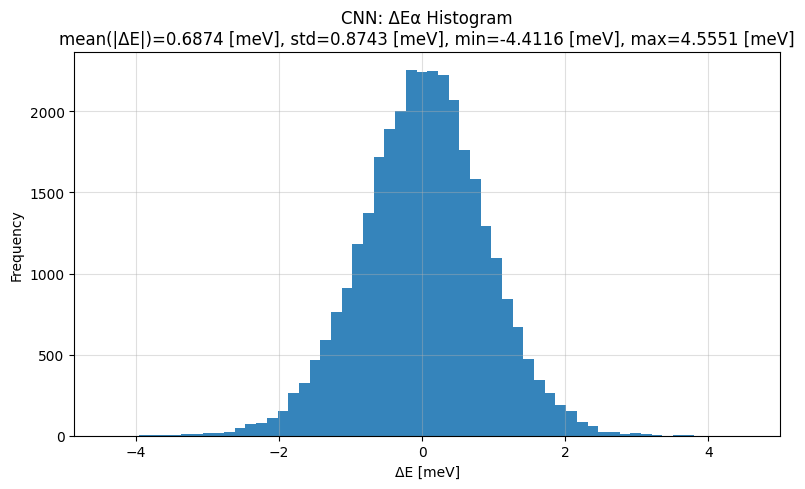

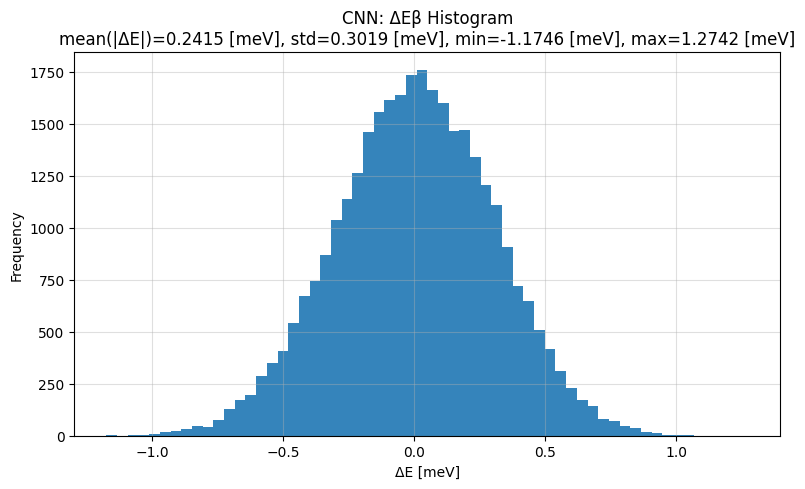

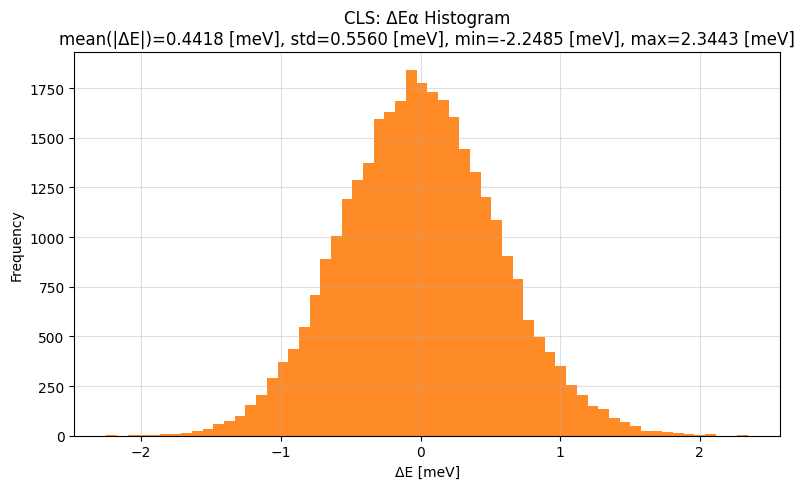

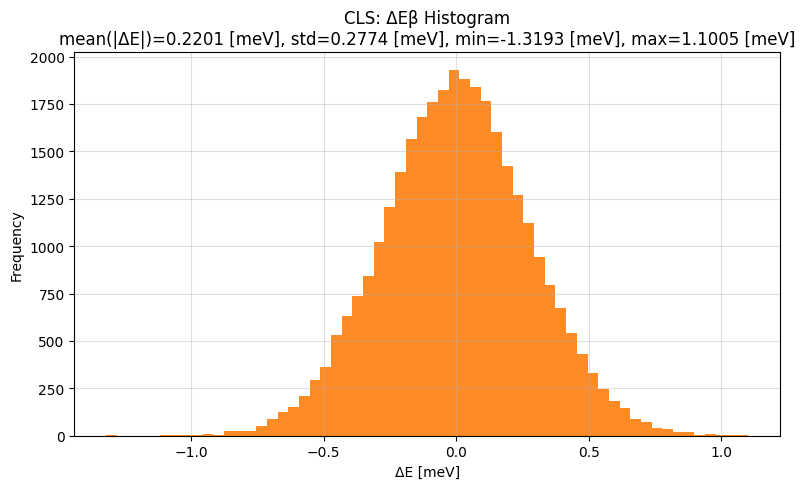

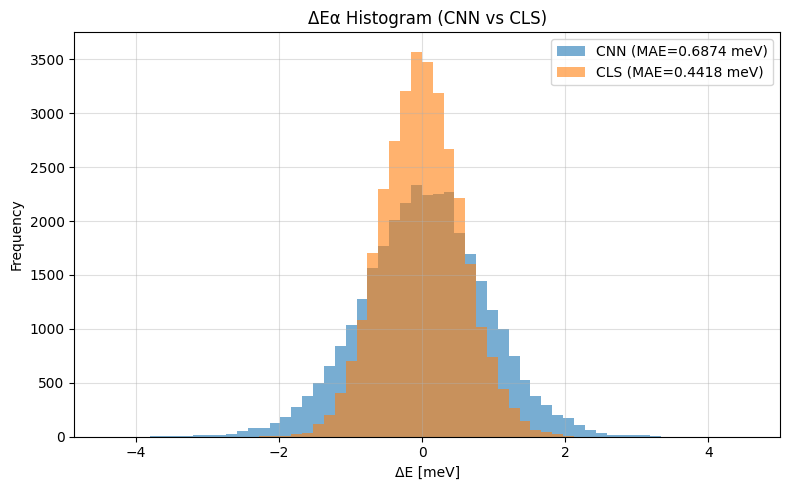

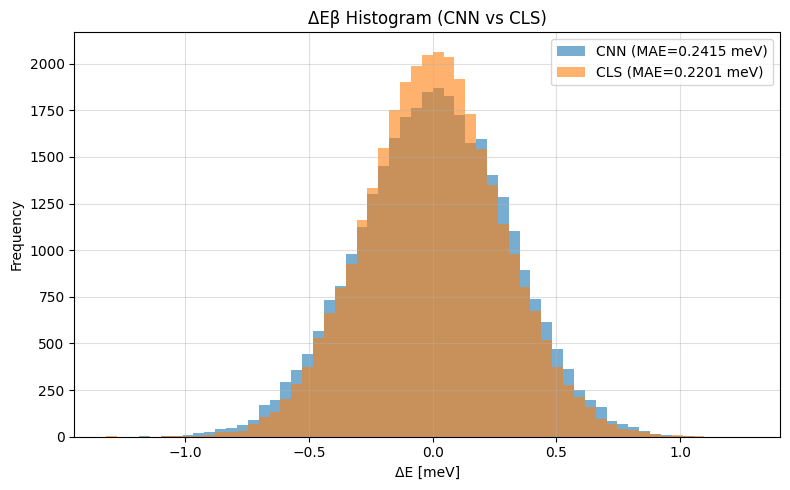

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 前提：
# y_true_cnn, y_pred_cnn: shape (N, 2) -> [Eα, Eβ]  (unit: meV)
# y_true_cls, y_pred_cls: shape (N, 2) -> [Eα, Eβ]  (unit: meV)

###############################################
# 1. 誤差（ΔE）の計算
###############################################
# CNN
delta_alpha_cnn = y_pred_cnn[:, 0] - y_true_cnn[:, 0]   # ΔEα [meV]
delta_beta_cnn  = y_pred_cnn[:, 1] - y_true_cnn[:, 1]   # ΔEβ [meV]

# CLS
delta_alpha_cls = y_pred_cls[:, 0] - y_true_cls[:, 0]   # ΔEα [meV]
delta_beta_cls  = y_pred_cls[:, 1] - y_true_cls[:, 1]   # ΔEβ [meV]


###############################################
# 2. 統計情報
###############################################
def get_stats(arr):
    return {
        "mean": float(np.mean(arr)),          # 符号付き平均
        "std":  float(np.std(arr)),
        "min":  float(np.min(arr)),
        "max":  float(np.max(arr)),
        "mae":  float(np.mean(np.abs(arr)))   # |ΔE|の平均
    }

stats_alpha_cnn = get_stats(delta_alpha_cnn)
stats_beta_cnn  = get_stats(delta_beta_cnn)
stats_alpha_cls = get_stats(delta_alpha_cls)
stats_beta_cls  = get_stats(delta_beta_cls)


###############################################
# 3. 単一モデル用ヒストグラム描画
###############################################
def plot_hist_single(data, title, stats, color="steelblue"):
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=60, color=color, alpha=0.9)

    plt.title(
        f"{title}\n"
        f"mean(|ΔE|)={stats['mae']:.4f} [meV], "
        f"std={stats['std']:.4f} [meV], "
        f"min={stats['min']:.4f} [meV], "
        f"max={stats['max']:.4f} [meV]"
    )
    plt.xlabel("ΔE [meV]")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


###############################################
# 4. CNN / CLS を重ねて比較するヒストグラム
###############################################
def plot_hist_compare(data1, data2, title, stats1, stats2,
                      label1="CNN", label2="CLS"):
    plt.figure(figsize=(8,5))
    # 共通のビンを決める（両方の範囲をカバー）
    all_data = np.concatenate([data1, data2])
    bins = np.linspace(all_data.min(), all_data.max(), 60)

    plt.hist(data1, bins=bins, alpha=0.6, label=f"{label1} (MAE={stats1['mae']:.4f} meV)")
    plt.hist(data2, bins=bins, alpha=0.6, label=f"{label2} (MAE={stats2['mae']:.4f} meV)")

    plt.title(title)
    plt.xlabel("ΔE [meV]")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()


###############################################
# 5. 個別ヒスト（CNNのみ / CLSのみ）
###############################################

# CNN 単体
plot_hist_single(delta_alpha_cnn, "CNN: ΔEα Histogram", stats_alpha_cnn, color="tab:blue")
plot_hist_single(delta_beta_cnn,  "CNN: ΔEβ Histogram", stats_beta_cnn,  color="tab:blue")

# CLS 単体
plot_hist_single(delta_alpha_cls, "CLS: ΔEα Histogram", stats_alpha_cls, color="tab:orange")
plot_hist_single(delta_beta_cls,  "CLS: ΔEβ Histogram", stats_beta_cls,  color="tab:orange")


###############################################
# 6. CNN vs CLS 比較ヒスト
###############################################

# ΔEα の比較
plot_hist_compare(
    delta_alpha_cnn,
    delta_alpha_cls,
    "ΔEα Histogram (CNN vs CLS)",
    stats_alpha_cnn,
    stats_alpha_cls,
    label1="CNN",
    label2="CLS"
)

# ΔEβ の比較
plot_hist_compare(
    delta_beta_cnn,
    delta_beta_cls,
    "ΔEβ Histogram (CNN vs CLS)",
    stats_beta_cnn,
    stats_beta_cls,
    label1="CNN",
    label2="CLS"
)


In [ ]:
############################################################
# 12-b. 相対誤差 [%] の計算
############################################################

# CNN 側のラベル平均（meV）
Ea_mean_cnn = dset_cnn_full.y_mean[0]
Eb_mean_cnn = dset_cnn_full.y_mean[1]

rel_mae_Ea_cnn = mae_alpha_cnn / Ea_mean_cnn * 100.0
rel_mae_Eb_cnn = mae_beta_cnn  / Eb_mean_cnn * 100.0

# CLS 側のラベル平均（meV）
Ea_mean_cls = dset_cls_full.y_mean[0]
Eb_mean_cls = dset_cls_full.y_mean[1]

rel_mae_Ea_cls = mae_alpha_cls / Ea_mean_cls * 100.0
rel_mae_Eb_cls = mae_beta_cls  / Eb_mean_cls * 100.0

print("\n===== Relative MAE (%, using dataset mean as scale) =====")
print(f"[CNN] Ea: {rel_mae_Ea_cnn:.2f}%  (MAE={mae_alpha_cnn:.3f} meV, mean={Ea_mean_cnn:.3f} meV)")
print(f"[CNN] Eb: {rel_mae_Eb_cnn:.2f}%  (MAE={mae_beta_cnn:.3f} meV, mean={Eb_mean_cnn:.3f} meV)")
print(f"[CLS] Ea: {rel_mae_Ea_cls:.2f}%  (MAE={mae_alpha_cls:.3f} meV, mean={Ea_mean_cls:.3f} meV)")
print(f"[CLS] Eb: {rel_mae_Eb_cls:.2f}%  (MAE={mae_beta_cls:.3f} meV, mean={Eb_mean_cls:.3f} meV)")



===== Relative MAE (%, using dataset mean as scale) =====
[CNN] Ea: 6.85%  (MAE=0.687 meV, mean=10.041 meV)
[CNN] Eb: 1.07%  (MAE=0.241 meV, mean=22.498 meV)
[CLS] Ea: 4.40%  (MAE=0.442 meV, mean=10.041 meV)
[CLS] Eb: 0.98%  (MAE=0.220 meV, mean=22.498 meV)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import pickle
from pathlib import Path


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
class NoDenoisePSDDataset(Dataset):
    """
    ノイズ除去なし：
    structured + 外的ノイズをそのまま CNN に入力
    """

    def __init__(
        self,
        pickle_path,
        noise_level=0.3,
        freq_min=0.0,
        freq_max=3000.0,
    ):
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)

        self.x_clean = np.asarray(data["x"], dtype=np.float32)  # (N, L)
        self.y = np.asarray(data["y"], dtype=np.float32)        # (N, 2) Ea, Eb

        if self.x_clean.ndim == 3:
            self.x_clean = self.x_clean.squeeze(1)

        self.scale_factor = 2.5e24
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.noise_level = noise_level

        # 正規化統計（clean PSD 基準）
        self.mean, self.std = self._compute_log_stats()

        self.seq_len = self.x_clean.shape[1]

    def _compute_log_stats(self):
        scaled = self.x_clean * self.scale_factor
        scaled = np.maximum(scaled, 1e-30)
        logv = np.log(scaled)
        return float(logv.mean()), float(logv.std())

    def __len__(self):
        return len(self.x_clean)

    def __getitem__(self, idx):
        clean = torch.tensor(self.x_clean[idx])

        # 実験環境ノイズ
        structured = add_structured_noise(clean)

        # 外的ノイズ（除去しない）
        noisy, _, _ = add_noise_to_interval(
            structured,
            interval_idx=0,
            noise_type="power_supply",
            noise_level=self.noise_level,
            freq_min=self.freq_min,
            freq_max=self.freq_max,
        )

        # log + 正規化
        noisy = noisy.numpy()
        scaled = noisy * self.scale_factor
        scaled = np.maximum(scaled, 1e-30)
        logv = np.log(scaled)
        norm = (logv - self.mean) / (self.std + 1e-8)

        x = torch.tensor(norm, dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return x, y


In [ ]:
class PSDCNN(nn.Module):
    def __init__(self, seq_len):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),  # Ea, Eb
        )

    def forward(self, x):
        # x: (B, L)
        x = x.unsqueeze(1)      # (B, 1, L)
        h = self.conv(x)        # (B, 64, 1)
        h = h.squeeze(-1)       # (B, 64)
        out = self.fc(h)        # (B, 2)
        return out


In [ ]:
def train_cnn_no_denoise(
    pickle_path,
    noise_level=0.3,
    batch_size=128,
    num_epochs=50,
    lr=1e-3,
    val_ratio=0.2,
):
    dataset = NoDenoisePSDDataset(
        pickle_path=pickle_path,
        noise_level=noise_level,
    )

    n_total = len(dataset)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_val

    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = PSDCNN(dataset.seq_len).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float("inf")

    for epoch in range(num_epochs):
        # ---- train ----
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= n_train

        # ---- val ----
        model.eval()
        val_loss = 0.0
        preds, trues = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                pred = model(x)
                loss = criterion(pred, y)

                val_loss += loss.item() * x.size(0)
                preds.append(pred.cpu())
                trues.append(y.cpu())

        val_loss /= n_val

        preds = torch.cat(preds)
        trues = torch.cat(trues)
        mae = torch.mean(torch.abs(preds - trues), dim=0)

        print(
            f"Epoch {epoch+1:03d} | "
            f"Train MSE {train_loss:.6f} | "
            f"Val MSE {val_loss:.6f} | "
            f"MAE Ea {mae[0]:.6f}, Eb {mae[1]:.6f}"
        )

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "cnn_no_denoise_best.pth")

    return model, mae


In [ ]:
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"

cnn_no_denoise, mae_no_denoise = train_cnn_no_denoise(
    pickle_path=PICKLE_PATH,
    noise_level=0.3,
    num_epochs=50,
)

print("=== Final MAE (NO DENOISE) ===")
print(f"Ea MAE = {mae_no_denoise[0]:.6f}")
print(f"Eb MAE = {mae_no_denoise[1]:.6f}")


Epoch 001 | Train MSE 0.389089 | Val MSE 0.180638 | MAE Ea 0.511028, Eb 0.068892
Epoch 002 | Train MSE 0.159999 | Val MSE 0.135753 | MAE Ea 0.445241, Eb 0.054887
Epoch 003 | Train MSE 0.033254 | Val MSE 0.006814 | MAE Ea 0.087608, Eb 0.032087
Epoch 004 | Train MSE 0.005643 | Val MSE 0.004793 | MAE Ea 0.072329, Eb 0.029858
Epoch 005 | Train MSE 0.004429 | Val MSE 0.005034 | MAE Ea 0.075344, Eb 0.028814
Epoch 006 | Train MSE 0.003938 | Val MSE 0.003612 | MAE Ea 0.061407, Eb 0.027747
Epoch 007 | Train MSE 0.003867 | Val MSE 0.003480 | MAE Ea 0.059935, Eb 0.029034
Epoch 008 | Train MSE 0.003574 | Val MSE 0.004889 | MAE Ea 0.073964, Eb 0.027822
Epoch 009 | Train MSE 0.003527 | Val MSE 0.003242 | MAE Ea 0.058432, Eb 0.026802
Epoch 010 | Train MSE 0.003323 | Val MSE 0.003007 | MAE Ea 0.055470, Eb 0.027023
Epoch 011 | Train MSE 0.003488 | Val MSE 0.002924 | MAE Ea 0.054185, Eb 0.027919
Epoch 012 | Train MSE 0.003253 | Val MSE 0.003107 | MAE Ea 0.053404, Eb 0.033289
Epoch 013 | Train MSE 0.0031